In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import torch
from torch import Tensor, nn

In [4]:
from torch.utils.data import DataLoader

from soundgen.datasets import TinyPianoDataset
from soundgen.transformations.preprocess import PreprocessingModule

from soundgen.models.vae import VAELit
from soundgen.configs import TrainConfig, VAEConfig

In [5]:
from lightning import Trainer

In [6]:
from soundgen.transformations.postprocess import SpectrogramToWaveformTransform
from IPython.display import Audio, display


In [7]:
from librosa.display import specshow, waveshow

# Load data and check pre-/postprocessing

In [8]:
top_folder = Path().resolve().parent
print(top_folder)

/Users/borispodolnyi/Documents/coding_projects/soundgen


In [9]:
sr = 22050
num_samples = 22050  # fix waveform length
n_fft = 512
hop_length = n_fft // 2
power = 1.0

# For Griffin-Lim inversion, STFT must have the true frequency dimension: n_fft//2 + 1
spec_freq_bins = n_fft // 2 + 1

# Time bins are roughly num_samples / hop_length (depends on STFT centering); keep fixed for VAE input size
spec_time_bins = int(np.ceil(num_samples / hop_length))
spec_time_bins

87

In [10]:
preprocessing = PreprocessingModule(
    sample_rate=sr,
    num_samples=num_samples,
    n_fft=n_fft,
    power=power,
    representation="stft",
    hop_length=hop_length,
    target_shape=(spec_freq_bins, spec_time_bins),
)

dataset = TinyPianoDataset(top_folder / "data/tiny_piano", transform=preprocessing, target_sr=sr)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
reconstruct_transform = SpectrogramToWaveformTransform(
    n_fft=n_fft,
    hop_length=hop_length,
    power=power,
    griffin_lim_n_iter=128,
    griffin_lim_momentum=0.99,
    griffin_lim_rand_init=True,
)

In [12]:
X, sr, lbl = dataset[0]

In [13]:
waveform = dataset.get_audio(0)

In [14]:
X.shape

torch.Size([1, 257, 87])

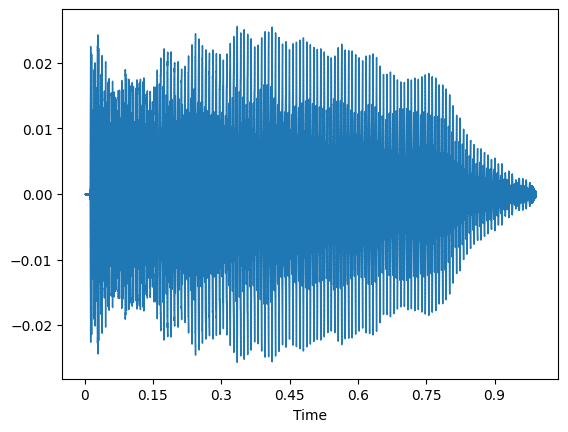

In [15]:
waveshow(waveform.numpy(), sr=sr)

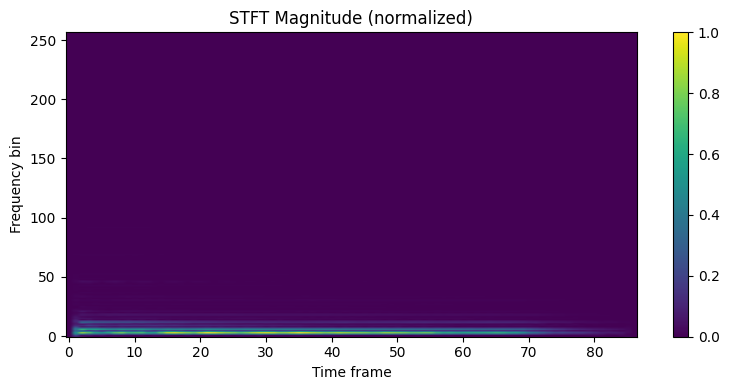

In [16]:
plt.figure(figsize=(8, 4))
im = plt.imshow(X.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(im, ax=plt.gca())
plt.title('STFT Magnitude (normalized)')
plt.xlabel('Time frame')
plt.ylabel('Frequency bin')
plt.tight_layout()
plt.show()

In [17]:
wave_recon = reconstruct_transform(X.squeeze(0))

In [18]:
waveform.abs().max(), np.abs(wave_recon).max()

(tensor(0.0256), np.float32(1.0))

In [19]:
display(Audio(waveform, rate=sr))

In [20]:
display(Audio(wave_recon, rate=sr))

# Init VAE

In [ ]:
# vae_config = VAEConfig.from_json(top_folder / "configs/vae_1d.json")
vae_config = VAEConfig(**{
    "input_shape": [1, spec_freq_bins, spec_time_bins],
    "conv_filters_number": [128, 64, 32, 32, 16],
    "conv_kernel_size": [4, 4, 4, 3, 3],
    "conv_strides": [2, 2, 2, 1, 1],
    "latent_space_dim": 32,
    "shape_before_bottleneck": None,

    "kl_weight": 0.001,
    "warmup_epochs": 20,
    "autoencode": False, # if True – use vanilla AE, else VAE

})

In [ ]:
# Create training configuration
train_config = TrainConfig(
    num_epochs=1000,
    learning_rate=0.0005,
    batch_size=19
)

In [31]:
# vae_config.input_shape = list(X.shape)

In [32]:
vae_lit = VAELit(learning_rate=train_config.learning_rate, **vae_config.to_dict())

# Training

## Set up

In [53]:
# Initialize trainer
# trainer = Trainer(max_epochs=train_config.num_epochs, gradient_clip_val=1.0)
trainer = Trainer(max_epochs=500, gradient_clip_val=1.0)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


## Run

In [54]:
%%time
trainer.fit(vae_lit, train_loader)


  | Name    | Type    | Params | Mode | FLOPs
---------------------------------------------------
0 | model   | VAE     | 857 K  | eval | 0    
1 | loss_fn | VAELoss | 0      | eval | 0    
---------------------------------------------------
857 K     Trainable params
0         Non-trainable params
857 K     Total params
3.431     Total estimated model params size (MB)
0         Modules in train mode
45        Modules in eval mode
0         Total Flops
/Users/borispodolnyi/Documents/coding_projects/soundgen/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/borispodolnyi/Documents/coding_projects/soundgen/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:317: The number of training batches (1) is smaller than the log

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


CPU times: user 40.7 s, sys: 13.3 s, total: 54.1 s
Wall time: 3min 22s


# Generate sounds

## Load from checkpoint

In [21]:
latest_log_version = sorted([int(f.name.split('_')[-1]) for f in list(Path('lightning_logs').glob('*'))])[-1]
latest_log_version

63

In [22]:
# last ok 45, 59, 61(?)

In [116]:
# checkpoint_version = latest_log_version
checkpoint_version = 63
checkpoint_files = list((top_folder / f"experiments/lightning_logs/version_{checkpoint_version}/checkpoints").glob("*.ckpt"))
checkpoint_file = checkpoint_files[0]
checkpoint_file

PosixPath('/Users/borispodolnyi/Documents/coding_projects/soundgen/experiments/lightning_logs/version_63/checkpoints/epoch=499-step=500.ckpt')

In [117]:
h_params_file = top_folder / f"experiments/lightning_logs/version_{checkpoint_version}/hparams.yaml"
assert h_params_file.exists()
vae_config = VAEConfig.from_yaml(h_params_file)


In [118]:
vae_lit = VAELit.load_from_checkpoint(checkpoint_file, **vae_config.to_dict())

## Reconstruct audio

In [119]:
vae_lit.to('cpu')

VAELit(
  (model): VAE(
    (encoder): Encoder(
      (mu): Linear(in_features=5120, out_features=32, bias=True)
      (log_var): Linear(in_features=5120, out_features=32, bias=True)
      (conv_layers): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        (5): ReLU()
        (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): GroupNorm(8, 32, eps=1e-05, affine=True)
        (8): ReLU()
        (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (10): GroupNorm(8, 32, eps=1e-05, affine=True)
        (11): ReLU()
        (12): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): GroupNorm(8, 16, eps=1e-05, affine=True)
        (14): ReLU()
      )
    

In [120]:
vae_lit.eval()

VAELit(
  (model): VAE(
    (encoder): Encoder(
      (mu): Linear(in_features=5120, out_features=32, bias=True)
      (log_var): Linear(in_features=5120, out_features=32, bias=True)
      (conv_layers): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): GroupNorm(8, 128, eps=1e-05, affine=True)
        (2): ReLU()
        (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (4): GroupNorm(8, 64, eps=1e-05, affine=True)
        (5): ReLU()
        (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (7): GroupNorm(8, 32, eps=1e-05, affine=True)
        (8): ReLU()
        (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (10): GroupNorm(8, 32, eps=1e-05, affine=True)
        (11): ReLU()
        (12): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): GroupNorm(8, 16, eps=1e-05, affine=True)
        (14): ReLU()
      )
    

In [121]:
vae_lit.model.eval()

VAE(
  (encoder): Encoder(
    (mu): Linear(in_features=5120, out_features=32, bias=True)
    (log_var): Linear(in_features=5120, out_features=32, bias=True)
    (conv_layers): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): GroupNorm(8, 128, eps=1e-05, affine=True)
      (2): ReLU()
      (3): Conv2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): GroupNorm(8, 64, eps=1e-05, affine=True)
      (5): ReLU()
      (6): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): GroupNorm(8, 32, eps=1e-05, affine=True)
      (8): ReLU()
      (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): GroupNorm(8, 32, eps=1e-05, affine=True)
      (11): ReLU()
      (12): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): GroupNorm(8, 16, eps=1e-05, affine=True)
      (14): ReLU()
    )
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder)

In [122]:
type(vae_lit.model.decoder)

soundgen.models.vae.DecoderUpsample

In [123]:
idx = 10
X = dataset[idx][0].unsqueeze(0).to('cpu')
X_reconstructed = vae_lit.model(X)

waveform_recon = reconstruct_transform(X_reconstructed.squeeze(0).squeeze(0).detach())
waveform_orig = dataset.get_audio(idx).numpy()
waveform_orig_recon = reconstruct_transform(X.squeeze(0).squeeze(0).detach())

In [124]:
display(Audio(waveform_orig, rate=sr))

In [125]:
display(Audio(waveform_recon, rate=sr))

In [126]:
display(Audio(waveform_orig_recon, rate=sr))

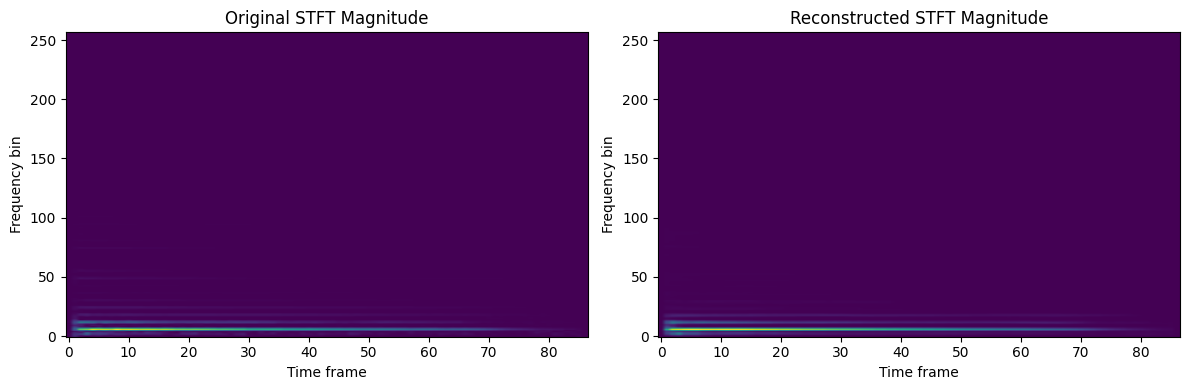

In [127]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot original spectrogram
axes[0].imshow(X.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[0].set_title('Original STFT Magnitude')
axes[0].set_xlabel('Time frame')
axes[0].set_ylabel('Frequency bin')

# Plot reconstructed spectrogram
axes[1].imshow(X_reconstructed.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='viridis')
axes[1].set_title('Reconstructed STFT Magnitude')
axes[1].set_xlabel('Time frame')
axes[1].set_ylabel('Frequency bin')

plt.tight_layout()
plt.show()

## Reconstruct all train samples

In [128]:
def reconstruct_waveform(idx: int) -> tuple[np.ndarray, np.ndarray]:
    X = dataset[idx][0].unsqueeze(0)
    X_reconstructed = vae_lit.model(X)
    waveform_recon = reconstruct_transform(X_reconstructed.squeeze(0).squeeze(0).detach())
    waveform_orig = dataset.get_audio(idx).numpy()
    return waveform_recon, waveform_orig

In [129]:
waveform_recon_all = []
for i in range(len(dataset)):
    waveform_recon, waveform_orig = reconstruct_waveform(i)
    waveform_recon_all.append(waveform_recon)

In [130]:
all_scale = np.concat(waveform_recon_all)
display(Audio(all_scale, rate=sr))

## Generate from latent

In [131]:
class GenDecoder(torch.nn.Module):
    def __init__(self, vae_decoder: nn.Module, inverse_transform: nn.Module):
        super().__init__()
        self.vae_decoder = vae_decoder
        self.inverse_transform = inverse_transform

    def forward(self, x):
        decoded = self.vae_decoder(x)
        return self.inverse_transform(decoded.detach())

In [132]:
gen_decoder = GenDecoder(vae_lit.model.decoder, reconstruct_transform)

### Test microtonality

In [133]:
ids = [11, 12]

In [134]:
display(Audio(dataset.get_audio(ids[0]), rate=sr))

In [135]:
display(Audio(dataset.get_audio(ids[1]), rate=sr))

In [136]:
latents = []
for i in ids:
    X = dataset[i][0].unsqueeze(0)
    latent_mu, latent_logvar = vae_lit.model.encoder(X)
    latents.append(vae_lit.model.reparameterize(latent_mu, latent_logvar))

In [137]:
display(Audio(gen_decoder(latents[0]), rate=sr))

In [138]:
x_avg = torch.mean(torch.stack(latents), dim=0) # averaging in latent space produces sound in between the originals
display(Audio(gen_decoder(x_avg), rate=sr))

In [139]:
display(Audio(gen_decoder(latents[1]), rate=sr))